In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

DATA_DIRECTORY = os.getenv('DATA_DIRECTORY')
DATA_PATH = os.path.join(DATA_DIRECTORY, 'data.csv')

In [2]:
import csv
import numpy as np

sentences = []
labels = []

file = open(DATA_PATH, 'r', encoding='utf-8')
csvreader = csv.reader(file)
_ = next(csvreader)
for row in csvreader:
    sentences.append(row[0])
    labels.append(int(row[1]))
file.close()

features, targets = np.array(sentences), np.array(labels)

In [3]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_targets, test_targets = train_test_split(
        features, targets,
        train_size=0.8,
        test_size=0.2,
        random_state=42,
        shuffle=True,
        stratify=targets
)

print(f'training samples size: {len(train_features)}'
    f'\ntesting samples size: {len(test_features)}')

training samples size: 852923
testing samples size: 213231


In [4]:
import tensorflow as tf

VOCAB_SIZE = 35000
EMBEDDING_DIM = 512
MAX_LENGTH = 50

print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE+2,
    output_mode='int',
    output_sequence_length=MAX_LENGTH,
)
vectorize_layer.adapt(train_features)
vocab = vectorize_layer.get_vocabulary(include_special_tokens=False)

In [6]:
from gensim.models import KeyedVectors

VECTOR_SIZE = 512
glove_file = os.path.join(DATA_DIRECTORY, f'GloVe.Reddit.120B.{VECTOR_SIZE}D.txt')
wv_model = KeyedVectors.load_word2vec_format(glove_file)
print(f'GloVe vocab size: {len(wv_model)}')

GloVe vocab size: 1623397


In [7]:
embedding_vectors = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for i, word in enumerate(vocab):
    if word in wv_model:
        embedding_vectors[i] = wv_model[word]

embedding_layer = tf.keras.layers.Embedding(
    VOCAB_SIZE, EMBEDDING_DIM,
    weights=[embedding_vectors],
    input_length=MAX_LENGTH
)

In [8]:
# model = tf.keras.Sequential([
#     vectorize_layer,
#     tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
#     tf.keras.layers.SpatialDropout1D(0.4),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(units=128, dropout=0.2, return_sequences=True)
#     ),
#     tf.keras.layers.GlobalMaxPool1D(),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(units=16, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(units=1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [9]:
model = tf.keras.Sequential([
    vectorize_layer,
    embedding_layer,
    # tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=128, dropout=0.2)
    ),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 50, 512)           17920000  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              656384    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 18,576,641
Trainable params: 18,576,641
Non-trainable params: 0
_________________________________________________________________


In [10]:
NUM_EPOCHS = 25
BATCH_SIZE = 64
VERSION = 3

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history = model.fit(
    x=train_features, y=train_targets,
    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(test_features, test_targets),
    callbacks=[callback], verbose=1
)

MODEL_DIRECTORY = os.getenv('MODEL_DIRECTORY')
export_path = os.path.join(MODEL_DIRECTORY, 'sarcasm_model', str(VERSION))
model.save(export_path)

Epoch 1/25
13327/13327 [==============================] - 249s 18ms/step - loss: 0.5565 - accuracy: 0.7107 - val_loss: 0.5311 - val_accuracy: 0.7309
Epoch 2/25
13327/13327 [==============================] - 237s 18ms/step - loss: 0.4996 - accuracy: 0.7533 - val_loss: 0.5262 - val_accuracy: 0.7377
Epoch 3/25
13327/13327 [==============================] - 239s 18ms/step - loss: 0.4578 - accuracy: 0.7805 - val_loss: 0.5359 - val_accuracy: 0.7354
Epoch 4/25
13327/13327 [==============================] - 238s 18ms/step - loss: 0.4195 - accuracy: 0.8031 - val_loss: 0.5571 - val_accuracy: 0.7322
Epoch 5/25
13327/13327 [==============================] - 238s 18ms/step - loss: 0.3847 - accuracy: 0.8228 - val_loss: 0.5873 - val_accuracy: 0.7290


INFO:tensorflow:Assets written to: /Users/zanzi/Code/discord-sarcasm-bot/sarcasm_detection/models\sarcasm_model\3\assets


INFO:tensorflow:Assets written to: /Users/zanzi/Code/discord-sarcasm-bot/sarcasm_detection/models\sarcasm_model\3\assets


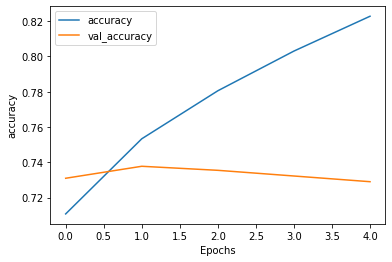

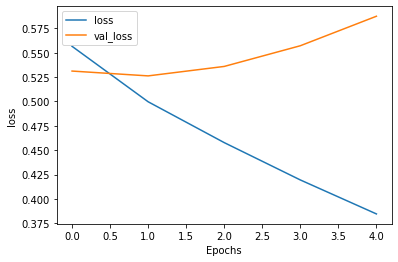

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score

probs = model.predict(test_features)
pred = np.where(probs > 0.75, 1,0)
cm = confusion_matrix(test_targets, pred)
print(accuracy_score(test_targets, pred))

0.709530978141077


<AxesSubplot:>

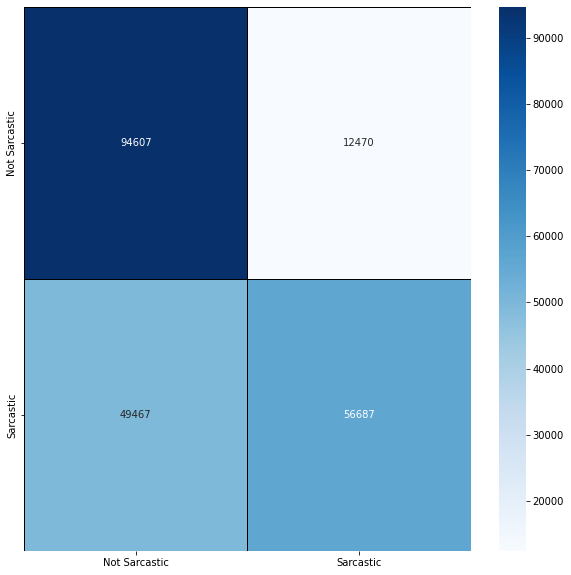

In [13]:
import pandas as pd
import seaborn as sns

cm = pd.DataFrame(
    data=cm,
    index=['Not Sarcastic','Sarcastic'],
    columns=['Not Sarcastic','Sarcastic']
)
plt.figure(figsize = (10,10))
sns.heatmap(
    data=cm, cmap="Blues", linecolor='black',
    linewidth=1, annot=True, fmt='',
    xticklabels = ['Not Sarcastic','Sarcastic'],
    yticklabels = ['Not Sarcastic','Sarcastic']
)